In [1]:
%load_ext autoreload
%autoreload 2
from transformer import SpeechTransformer
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, BinaryDataset, create_sampler
from training_pipeline import repeat_training, set_seed, worker_init_fn, plot_results
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SEED = 42
set_seed(SEED)
repetitions = 4
lr = 0.001
epochs = 100
tolerance = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alpha = 1
dropout = 0.3
weight_decay = 0.0001
augmented_fraction = 0.5
label_smoothing = 0.1

batch_size = 256
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

In [3]:
data_path = "data/train/audio_transformed"
train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN, augmentation=True, augmented_fraction=augmented_fraction)
val_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.VAL)
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)

sampler = create_sampler(train_dataset, alpha)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

## model dim

In [4]:
# d_model = 128
nhead = 4
num_layers = 4

set_seed(SEED)

d_model_list = [64, 128, 256]
for d_model in d_model_list:
     
     def init_transformer():
          return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)
     
     model_dir = f"output/models/all_classes/transformer/d_model/d_model={d_model}"
     history_dir = f"output/history/all_classes/transformer/d_model/d_model={d_model}"
     
     os.makedirs(model_dir, exist_ok=True)
     os.makedirs(history_dir, exist_ok=True)
     
     model_path = model_dir + "/transformer.pth"
     history_path = history_dir + "/transformer.pkl"
     
     repeat_training(repetitions, init_transformer, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay, label_smoothing=label_smoothing)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.009427208298245008, training accuracy: 9.327043532727842, training balanced accuracy: 9.275828785753015
epoch: 1, validation loss: 0.00987316486098269, validation accuracy: 5.030891438658429, validation balanced accuracy: 11.950824150151316
model saved

epoch: 2, training loss: 0.009153978049176411, training accuracy: 14.676636392107735, training balanced accuracy: 14.619470615649599
epoch: 2, validation loss: 0.009753150882423537, validation accuracy: 7.355104442483083, validation balanced accuracy: 17.803500309579885
model saved

epoch: 3, training loss: 0.008872187888028665, training accuracy: 18.947698089570938, training balanced accuracy: 18.907410424326418
epoch: 3, validation loss: 0.009955422251881764, validation accuracy: 9.620476610767874, validation balanced accuracy: 23.11615723818342

epoch: 4, training loss: 0.008338821081767214, training accuracy: 26.61681803946132, training balanced accuracy: 26.

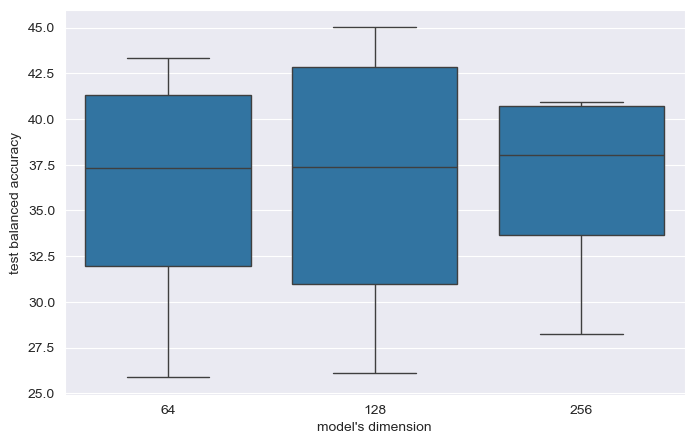

In [5]:
d_model_root_dir = "output/history/all_classes/transformer/d_model"
d_model_list = [64, 128, 256]
x_label = "model's dimension"
plot_results(d_model_root_dir, d_model_list, x_label, use_balanced_accuracy=True)

## number of heads

In [6]:
d_model = 128 # None # optimal or 128 
num_layers = 4

set_seed(SEED)

nhead_list = [2, 4, 8]
for nhead in nhead_list:
     
     def init_transformer():
          return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)
     
     model_dir = f"output/models/all_classes/transformer/nhead/nhead={nhead}"
     history_dir = f"output/history/all_classes/transformer/nhead/nhead={nhead}"
     
     os.makedirs(model_dir, exist_ok=True)
     os.makedirs(history_dir, exist_ok=True)
     
     model_path = model_dir + "/transformer.pth"
     history_path = history_dir + "/transformer.pkl"
     
     repeat_training(repetitions, init_transformer, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay, label_smoothing=label_smoothing)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.009468959839859988, training accuracy: 9.06866583150642, training balanced accuracy: 9.008652181171716
epoch: 1, validation loss: 0.009351419469615086, validation accuracy: 3.618711385701677, validation balanced accuracy: 9.090909090909092
model saved

epoch: 2, training loss: 0.009299939053207217, training accuracy: 11.883416849357971, training balanced accuracy: 11.902056850877447
epoch: 2, validation loss: 0.009580460777350053, validation accuracy: 7.25213298028832, validation balanced accuracy: 17.505867189444093

epoch: 3, training loss: 0.008966779367250967, training accuracy: 17.30543376135296, training balanced accuracy: 17.206577977856263
epoch: 3, validation loss: 0.00956138736116567, validation accuracy: 8.340688437775816, validation balanced accuracy: 20.005777054186147

epoch: 4, training loss: 0.008664499759450064, training accuracy: 21.821171312245536, training balanced accuracy: 21.86636258939914

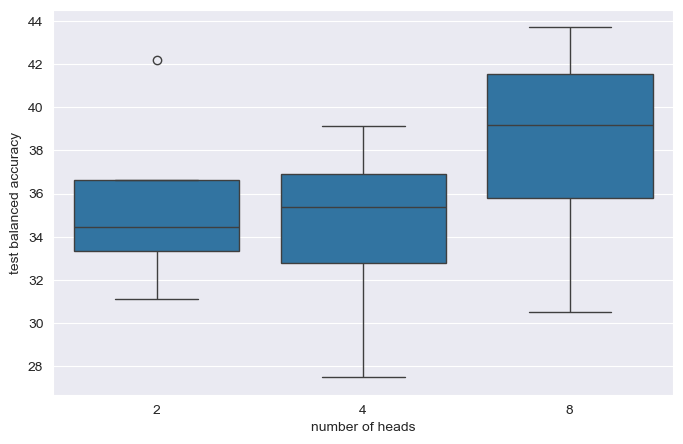

In [7]:
nhead_root_dir = "output/history/all_classes/transformer/nhead"
nhead_list = [2, 4, 8]
x_label = "number of heads"
plot_results(nhead_root_dir, nhead_list, x_label, use_balanced_accuracy=True)

## number of layers

In [8]:
d_model = 128 # None # optimal or 128
nhead = 8 # = None # optimal or 4

set_seed(SEED)

num_layers_list = [2, 4, 8]
for num_layers in num_layers_list:
     
     def init_transformer():
          return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)
     
     model_dir = f"output/models/all_classes/transformer/num_layers/num_layers={num_layers}"
     history_dir = f"output/history/all_classes/transformer/num_layers/num_layers={num_layers}"
     
     os.makedirs(model_dir, exist_ok=True)
     os.makedirs(history_dir, exist_ok=True)
     
     model_path = model_dir + "/transformer.pth"
     history_path = history_dir + "/transformer.pkl"
     
     repeat_training(repetitions, init_transformer, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay, label_smoothing=label_smoothing)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.009305163699931722, training accuracy: 12.758377701221422, training balanced accuracy: 12.757423591423281
epoch: 1, validation loss: 0.009016128489816142, validation accuracy: 17.563989408649604, validation balanced accuracy: 17.249397800914938
model saved

epoch: 2, training loss: 0.0089246227968609, training accuracy: 18.182352020043847, training balanced accuracy: 18.29305587523489
epoch: 2, validation loss: 0.009109092253241408, validation accuracy: 12.018240659017358, validation balanced accuracy: 23.30689866007904

epoch: 3, training loss: 0.008347571022152863, training accuracy: 26.769495772001253, training balanced accuracy: 26.650042409276413
epoch: 3, validation loss: 0.009459756584369495, validation accuracy: 13.606943218593704, validation balanced accuracy: 26.682324621941905

epoch: 4, training loss: 0.007924934539382748, training accuracy: 32.6475884747886, training balanced accuracy: 32.6765914989

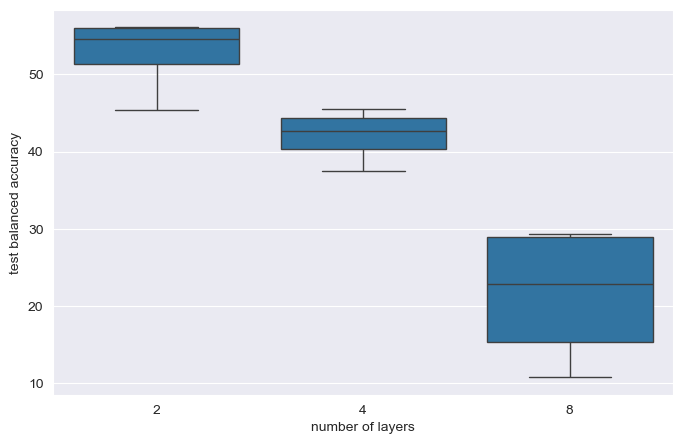

In [9]:
num_layers_root_dir = "output/history/all_classes/transformer/num_layers"
num_layers_list = [2, 4, 8]
x_label = "number of layers"
plot_results(num_layers_root_dir, num_layers_list, x_label, use_balanced_accuracy=True)

In [10]:
# results
d_model = 128
nhead = 8
num_layers = 2